#SVM MODEL BUILD

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Train and Test Datasets

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight


# Set dataset directory path
dataset_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/"

# Load preprocessed train and test sets
train_df = pd.read_csv(dataset_path + "train.csv")
test_df = pd.read_csv(dataset_path + "test.csv")

print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

Train dataset shape: (1515164, 16)
Test dataset shape: (726426, 16)


# Separate Features and Labels

In [3]:
label_column = 'Label'
feature_columns = [col for col in train_df.columns if col != label_column]

X_train, y_train = train_df[feature_columns], train_df[label_column]
X_test, y_test = test_df[feature_columns], test_df[label_column]

y_train, label_encoder = pd.factorize(y_train)
y_test = label_encoder.get_indexer(y_test)

print(f"Feature columns: {len(feature_columns)}, Label classes: {len(label_encoder)}")
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Feature columns: 15, Label classes: 13
Training samples: 1515164, Testing samples: 726426


# Define and Train the SVM Model

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
weights_dict = dict(zip(np.unique(y_train), class_weights))


# rbf_feature = RBFSampler(gamma=1, random_state=1)  # Kernel approximation
# X_train_transformed = rbf_feature.fit_transform(X_train)

base_model = SGDClassifier(loss="hinge", max_iter=20, class_weight=weights_dict)
model = CalibratedClassifierCV(base_model, cv=5)  # Calibrates during training

start = time.time()
model.fit(X_train, y_train)
# model.score(X_train_transformed, y_train)
end = time.time()

print('ELAPSED TIME MODEL TRAINING:', (end - start) / 60, 'min')


# Perform Predictions

In [21]:
import time
start = time.time()
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
end = time.time()
print(f'Elapsed Prediction Time: {(end - start)/60:.2f} minutes')

Elapsed Prediction Time: 0.37 minutes


# Perform Predictions

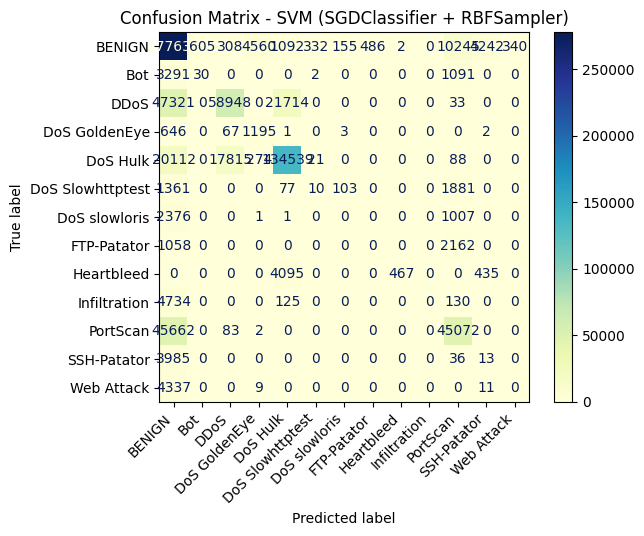


Classification Report:
                  precision    recall  f1-score   support

          BENIGN       0.67      0.93      0.78    300000
             Bot       0.05      0.01      0.01      4414
            DDoS       0.76      0.46      0.57    128016
   DoS GoldenEye       0.20      0.62      0.30      1914
        DoS Hulk       0.83      0.78      0.80    172849
DoS Slowhttptest       0.03      0.00      0.01      3432
   DoS slowloris       0.00      0.00      0.00      3385
     FTP-Patator       0.00      0.00      0.00      3220
      Heartbleed       1.00      0.09      0.17      4997
    Infiltration       0.00      0.00      0.00      4989
        PortScan       0.73      0.50      0.59     90819
     SSH-Patator       0.00      0.00      0.00      4034
      Web Attack       0.00      0.00      0.00      4357

        accuracy                           0.71    726426
       macro avg       0.33      0.26      0.25    726426
    weighted avg       0.71      0.71      0.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

encoder_path = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/2_Modeling-Phase/train_and_test_datasets/CICIDS-2017/label_encoder.pkl"
label_encoder = joblib.load(encoder_path)

# ✅ Convert class labels to strings
class_names = [str(cls) for cls in label_encoder.classes_]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='YlGnBu', values_format='d')

plt.title('Confusion Matrix - SVM (SGDClassifier + RBFSampler)')
plt.xticks(rotation=45, ha="right")
plt.show()


print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Compute Performance Metrics

In [23]:
def ACC(TP, TN, FP, FN):
    return (TP + TN) / (TP + FP + FN + TN)

def PRECISION(TP, FP):
    return TP / (TP + FP)

def RECALL(TP, FN):
    return TP / (TP + FN)

def F1(Recall, Precision):
    return 2 * Recall * Precision / (Recall + Precision)

def BACC(TP, TN, FP, FN):
    return (TP / (TP + FN) + TN / (TN + FP)) * 0.5

def MCC(TP, TN, FP, FN):

    TP, TN, FP, FN = map(np.float64, [TP, TN, FP, FN])

    numerator = (TN * TP - FN * FP)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    if denominator == 0:
        return 0

    return np.clip(numerator / denominator, -1, 1)

# Extract True Positives, False Positives, False Negatives, and True Negatives
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Compute Metrics
Acc = ACC(sum(TP), sum(TN), sum(FP), sum(FN))
Precision = PRECISION(sum(TP), sum(FP))
Recall = RECALL(sum(TP), sum(FN))
F1_score = F1(Recall, Precision)
BACC_score = BACC(sum(TP), sum(TN), sum(FP), sum(FN))
MCC_score = MCC(sum(TP), sum(TN), sum(FP), sum(FN))

# Print Performance Metrics
print(f'Accuracy: {Acc:.4f}')
print(f'Precision: {Precision:.4f}')
print(f'Recall: {Recall:.4f}')
print(f'F1 Score: {F1_score:.4f}')
print(f'BACC: {BACC_score:.4f}')
print(f'MCC: {MCC_score:.4f}')

Accuracy: 0.9558
Precision: 0.7130
Recall: 0.7130
F1 Score: 0.7130
BACC: 0.8445
MCC: 0.6890


# Compute AUC-ROC Score

In [25]:
from sklearn.calibration import CalibratedClassifierCV
n_classes = len(label_encoder.classes_)
clf = CalibratedClassifierCV(model, cv="prefit")  # ✅ Wrap BEFORE training


y_test_binarized = label_binarize(y_test, classes=range(n_classes))
auc_score = roc_auc_score(y_test_binarized, y_proba, multi_class="ovr")

print(f"AUC-ROC Score: {auc_score:.4f}")

AUC-ROC Score: 0.9245


# Save the Trained SVM Model

In [26]:
model_folder = "/content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/"
model_filename = "CICIDS-2017_SVM_SGD.joblib"
model_path = model_folder + model_filename

joblib.dump(model, model_path)
print(f"SVM model saved to: {model_path}")

SVM model saved to: /content/drive/MyDrive/Colab Notebooks/XAI IDS Architecture/3_Post-Modeling-Phase/Trained_ML_models/Models_CICIDS-2017/CICIDS-2017_SVM_SGD.joblib
